In [88]:
import pymc3 as pm
import pandas as pd
import numpy as np
import pickle
from cmocean.cm import balance
from matplotlib import rcParams
from seaborn import heatmap
import matplotlib.pyplot as pl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from theano import tensor as tt

In [91]:
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['axes.titlesize'] = 18
rcParams['figure.titlesize'] = 20
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['font.size'] = 14

In [3]:
% matplotlib inline

In [100]:
def PosteriorPredictiveCheck(y_obs, trace, model, var='y_pred', num_samples=5000):
    ppc = pm.sample_ppc(trace, samples=num_samples, model=model)
    sig95 = pm.hpd(ppc[var])
    med_y_pred = np.median(ppc[var], axis=0)
    idx = np.argsort(y_obs)
    f, ax = pl.subplots( figsize=(12, 12))
    ax.plot(y_obs[idx], sig95[idx,0], marker='.', ls='')
    ax.plot(y_obs[idx], sig95[idx,1], marker='.', ls='')
    ax.plot(y_obs[idx], med_y_pred[idx], 'k--')
    return ax


def PlotCounts(y_obs, y_pred):
    f, ax = pl.subplots(figsize=(16, 5))
    avg_lndg_obs = np.mean(y_obs)
    avg_lndg_pre = np.mean(y_pred)
    x_obs, count_obs = np.unique(y_obs, return_counts=True)
    x_pred, count_pred = np.unique(y_pred, return_counts=True)
    ax.stem(x_obs, np.log(count_obs), linefmt='r', markerfmt='ro', basefmt='b-',
           label=r'observed; avg. strand $d^{-1}$: %.2f' % avg_lndg_obs)
    ax.stem(x_pred, np.log(count_pred), linefmt='k', markerfmt='k.', basefmt='b', alpha=0.1,
           label=r'predicted; avg. strand $d^{-1}$: %.2f' % avg_lndg_pre)
    ax.legend();

In [6]:
with open('../PklJar/CleanTrainSet.pkl', 'rb') as f:
    CleanTrainingSet = pickle.load(f)

In [7]:
dfFeatures = CleanTrainingSet['Features']
dfLabels = CleanTrainingSet['Labels']

In [8]:
dfFeatures.head()

,Ddelph_count,Lageno_count,FRDH,FRDV,OTTH,OTTV,Kp_index,Sunspot_No,Dst_index,AE_index,Pred_min,Pred_max,EasterlyWS,SoutherlyWS,WTMP,WVHT,APD,DPD
1999-03-07,0.0,0.0,20973.912083,49185.560903,17437.979625,53532.025069,35.125,65.0,-43.291667,447.416667,0.15,2.86,-1.597614,11.183859,2.666667,3.387917,6.396250,8.690000
1999-03-08,0.0,0.0,20990.983472,49181.313264,17456.633064,53532.310625,24.625,62.0,-26.375000,257.083333,0.24,2.79,-10.374381,7.568804,2.416667,2.469167,5.680000,9.164583
1999-03-09,0.0,0.0,21094.763472,49251.502500,17449.245519,53528.842847,34.500,95.0,-35.833333,461.125000,0.32,2.73,-8.124423,5.416860,2.400000,1.556087,5.028696,7.371304
1999-03-10,0.0,0.0,20977.871806,49174.146944,17433.556173,53506.013542,38.750,92.0,-44.458333,356.458333,0.37,2.68,-4.053519,2.885376,2.400000,1.031667,5.221667,9.026250
1999-03-11,0.0,0.0,20882.766944,49104.043333,17456.700552,53524.094653,29.125,114.0,-23.833333,237.625000,0.38,2.67,-7.269797,4.485525,2.358333,1.192500,4.812917,9.791250


Finding Principal Components that account for 95% of the variance

In [9]:
ss = StandardScaler()

In [10]:
X = dfFeatures.iloc[:, 2:]
X_s = ss.fit_transform(X)

In [18]:
pca = PCA(0.95)
pca_data = pca.fit_transform(X_s)

In [9]:
pca_data.shape

(4903, 11)

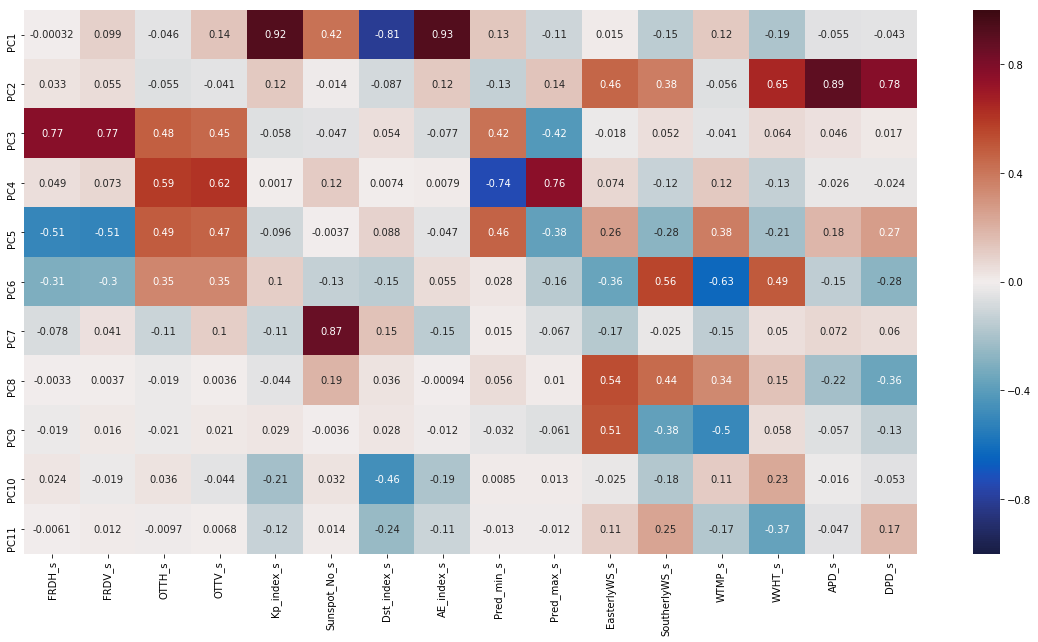

In [20]:
df_pca = pd.DataFrame(pca_data, columns=['PC%d' %(i+1)
                                         for i in range(pca_data.shape[1])])
dfX_s = pd.DataFrame(X_s, columns=['%s_s' % col for col in dfFeatures.columns[2:]])
dfcorr = pd.concat((df_pca, dfX_s), axis=1).corr()
dfcorr.drop(df_pca.columns, axis=1, inplace=True)
dfcorr.drop(dfX_s.columns, axis=0, inplace=True)
_, ax = pl.subplots(figsize=(20, 10))
heatmap(dfcorr, cmap=balance, vmin=-1, vmax=1, annot=True);

In [21]:
ss2 = StandardScaler()
X_pca_s = ss2.fit_transform(pca_data)
y_obs_all = dfLabels.NUM_ANIMALS.values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 11000/11000 [00:08<00:00, 1337.88it/s]


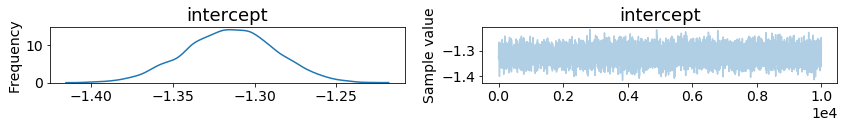

In [98]:
with pm.Model() as m0:
    intercept = pm.Normal('intercept', 0, 10)
    #lambda_ = pm.Deterministic('lambda_', pm.math.exp(intercept))
    lambda_ = tt.exp(intercept)
    y_pred_m0 = pm.Poisson('y_pred_m0', mu=lambda_, observed=y_obs_all)
    trace_m0 = pm.sample(10000, tune=1000)
pm.traceplot(trace_m0);

100%|██████████| 5000/5000 [00:01<00:00, 4055.57it/s]


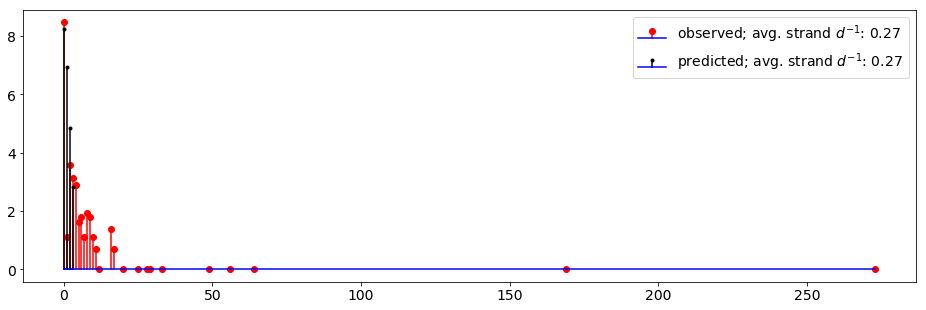

In [105]:
ppc = pm.sample_ppc(trace_m0, model=m0, samples=5000)
var = 'y_pred_m0'
y_pred_0 = ppc[var]
PlotCounts(y_obs_all, y_pred_0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 11000/11000 [00:44<00:00, 245.30it/s]


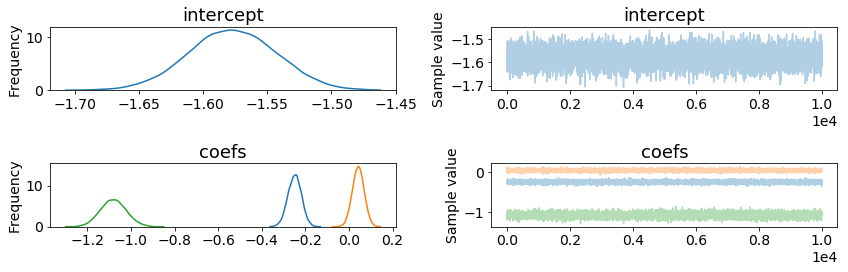

In [106]:
with pm.Model() as m1:
    intercept = pm.Normal('intercept', 0, 10)
    coefs = pm.Normal('coefs', 0, 10, shape=3)
    lambda_ = pm.math.exp(intercept + pm.math.dot(coefs, X_pca_s[:, :3].T))
    y_pred_m1 = pm.Poisson('y_pred_m1', lambda_, observed=y_obs_all)
    trace_m1 = pm.sample(10000, tune=1000)
pm.traceplot(trace_m1);

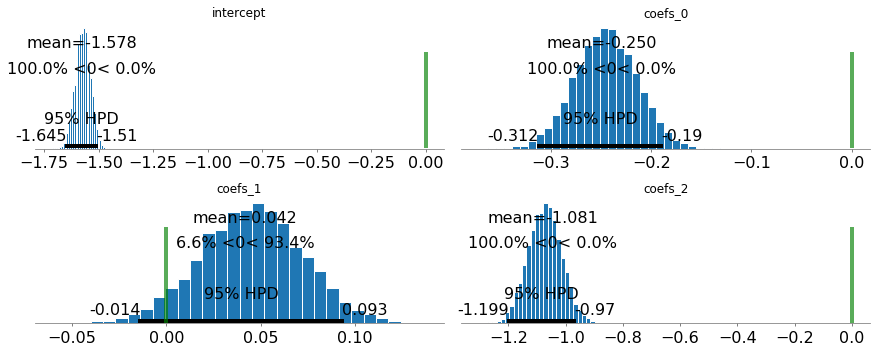

In [36]:
pm.plot_posterior(trace_m1, figsize=(12, 5), ref_val=0);

100%|██████████| 5000/5000 [00:04<00:00, 1046.85it/s]


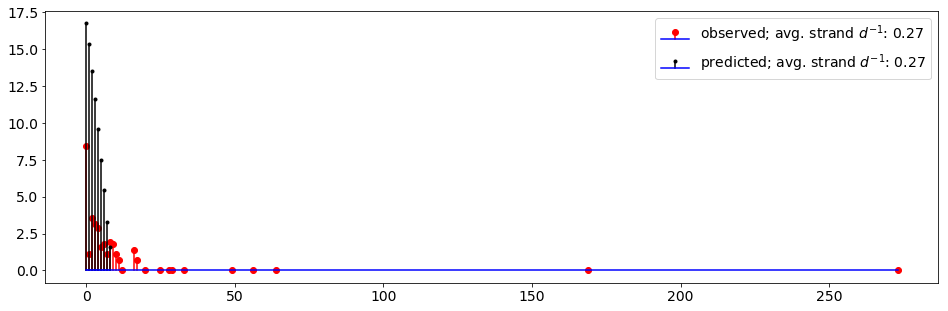

In [107]:
ppc = pm.sample_ppc(trace_m1, model=m1, samples=5000)
var = 'y_pred_m1'
y_pred_1 = ppc[var]
PlotCounts(y_obs_all, y_pred_1)

logp = -2,322.9, ||grad|| = 0.69957: 100%|██████████| 14/14 [00:00<00:00, 1202.30it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 11000/11000 [00:15<00:00, 730.72it/s]


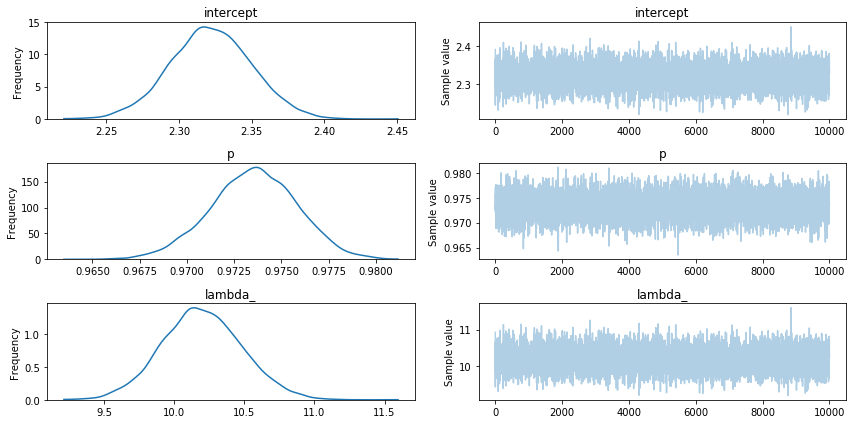

In [39]:
with pm.Model() as mzip0:
    p = pm.Beta('p', 1, 1)
    intercept = pm.Normal('intercept', 0, 10)
    lambda_ = pm.Deterministic('lambda_', pm.math.exp(intercept))
    y_pred_mzip0 = pm.ZeroInflatedPoisson('y_pred_mzip0', 1-p, lambda_, observed=y_obs_all)
    start=pm.find_MAP()
    trace_mzip0 = pm.sample(10000, tune=1000)
pm.traceplot(trace_mzip0);

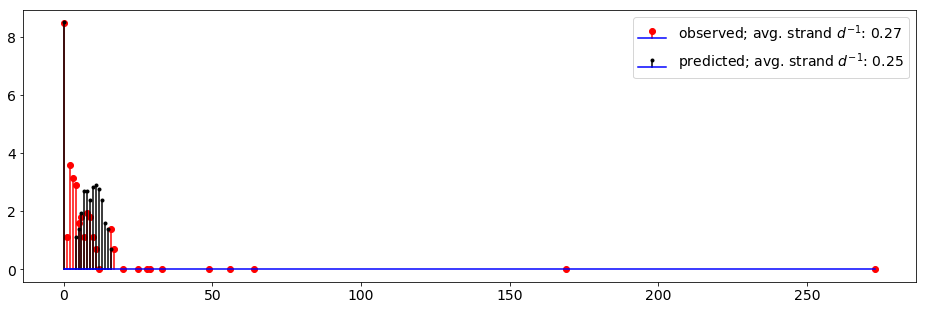

In [92]:
ppc = pm.sample_ppc(trace_mzip0, model=mzip0, samples=5000)
var = 'y_pred_mzip0'
y_pred_zip = ppc[var]
PlotCounts(y_obs_all, y_pred_zip)